In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("GOOGLE_API_KEY")
_set_env("GROQ_API_KEY")
_set_env("TAVILY_API_KEY")
_set_env('OPENAI_API_KEY')

In [1]:
import os
CURRENT_DIR = os.getcwd()
ROOT = os.path.dirname(CURRENT_DIR)
print("current" , CURRENT_DIR)
print("root" , ROOT)

current d:\Customer_support_bot\notebooks
root d:\Customer_support_bot


In [2]:
import os
import shutil
import requests
import sqlite3
import pandas as pd

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
backup_file = "travel2.backup.sqlite"
directory = os.path.join(ROOT, "db")

print(directory)


overwrite = False

os.makedirs(directory, exist_ok=True)
local_path = os.path.join(directory, local_file)
backup_path = os.path.join(directory, backup_file)

print(local_path)
print(backup_path)

if overwrite or not os.path.exists(local_path):
    print(f"Downloading database to {local_path}...")
    response = requests.get(db_url)
    response.raise_for_status()

    
    with open(local_path, 'wb') as f:
        f.write(response.content)
    shutil.copy(local_path, backup_path)
    print("Download and backup complete. ✅")
else:
    print("Database already exists. Skipping download.")


d:\Customer_support_bot\db
d:\Customer_support_bot\db\travel2.sqlite
d:\Customer_support_bot\db\travel2.backup.sqlite
Database already exists. Skipping download.


In [4]:
tables = {}
try:
    with sqlite3.connect(local_path) as conn:
        cursor = conn.cursor()
        cursor.execute("SELECT name FROM sqlite_master WHERE type = 'table'")
        table_names = [table[0] for table in cursor.fetchall()]

        print(f"Loading tables from {local_path}...")

        for table_name in table_names:
            df = pd.read_sql_query(f'SELECT * FROM {table_name}' , conn)

            tables[table_name] = df
            print(f" - Loaded table '{table_name}'")

except (sqlite3.Error, pd.errors.DatabaseError) as e:
        print(f"An error occurred: {e}")

Loading tables from db\travel2.sqlite...
 - Loaded table 'aircrafts_data'
 - Loaded table 'airports_data'
 - Loaded table 'boarding_passes'
 - Loaded table 'bookings'
 - Loaded table 'flights'
 - Loaded table 'seats'
 - Loaded table 'ticket_flights'
 - Loaded table 'tickets'
 - Loaded table 'car_rentals'
 - Loaded table 'hotels'
 - Loaded table 'trip_recommendations'


In [5]:
def update_dates(file):
    shutil.copy(backup_path, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_path)


In [6]:
import os
import re
import requests
from dotenv import load_dotenv

from langchain_core.tools import tool
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_chroma import Chroma

load_dotenv()


print("Loading and parsing the FAQ document...")
response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

print(faq_text)
docs_as_strings = re.split(r"(?=\n##)", faq_text)
docs = [Document(page_content=txt) for txt in docs_as_strings]
print(f"Loaded {len(docs)} document chunks.")


class VectorStoreRetriever:
    """A retriever that encapsulates a Chroma vector store."""
    def __init__(self, vector_store: Chroma):
        self.vector_store = vector_store

    @classmethod
    def from_documents(cls, docs: list[Document], embeddings, persist_directory: str):
        vector_store = Chroma.from_documents(
            documents=docs,
            embedding=embeddings,
            persist_directory=persist_directory,
        )
        return cls(vector_store)

    def query(self, query: str, k: int = 5) -> list[Document]:
        return self.vector_store.similarity_search(query, k=k)



persist_directory = os.path.join(os.getcwd(), "db", "chroma_db") 


embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

if os.path.exists(persist_directory):
    print("\nLoading existing OpenAI vector store from disk...")
    vector_store = Chroma(
        persist_directory=persist_directory, embedding_function=embeddings
    )
    retriever = VectorStoreRetriever(vector_store)
else:
    print("\nCreating new vector store with OpenAI embeddings...")
    retriever = VectorStoreRetriever.from_documents(
        docs=docs, embeddings=embeddings, persist_directory=persist_directory
    )
    print(f"Vector store created and saved to '{persist_directory}'")



@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted."""
    docs_result = retriever.query(query, k=2)
    return "\n\n".join([doc.page_content for doc in docs_result])

Loading and parsing the FAQ document...
## Invoice Questions

1. Can I receive an invoice for my booked flight?

Yes, we can send you a new booking confirmation free of charge for up to 100 days after the ticket/document has been completely used. A fee of CHF 30.00 per transaction (maximum of five E-ticket confirmations) will be charged after these 100 days. The E-ticket can be used for invoicing purposes.

2. Do I need to reconfirm my flight?

No, reconfirmation of SWISS flights is not required.

3. Can I check for availability and fares without booking a flight?

Yes, you can check flight availability and fares without finalizing a booking. The payment is only done in a last step, after entering your personal data.

4. What are the flight tariff categories?

The letters B,E,G,H,K,L,M,Q,S,T,U,V,W,Y (Economy Class), C,D,J,P,Z (Business Class), and A,F (First Class) are used to indicate the different price categories in the different service classes.

5. Where can I find the fare condit

### Flights

In [7]:
import sqlite3
from datetime import date, datetime
from typing import Optional

import pytz
from langchain_core.runnables import RunnableConfig


@tool
def fetch_user_flight_information(config: RunnableConfig) -> list[dict]:
    """Fetch all tickets for the user along with corresponding flight information and seat assignments.

    Returns:
        A list of dictionaries where each dictionary contains the ticket details,
        associated flight details, and the seat assignments for each ticket belonging to the user.
    """
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = """
    SELECT 
        t.ticket_no, t.book_ref,
        f.flight_id, f.flight_no, f.departure_airport, f.arrival_airport, f.scheduled_departure, f.scheduled_arrival,
        bp.seat_no, tf.fare_conditions
    FROM 
        tickets t
        JOIN ticket_flights tf ON t.ticket_no = tf.ticket_no
        JOIN flights f ON tf.flight_id = f.flight_id
        JOIN boarding_passes bp ON bp.ticket_no = t.ticket_no AND bp.flight_id = f.flight_id
    WHERE 
        t.passenger_id = ?
    """
    cursor.execute(query, (passenger_id,))
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def search_flights(
    departure_airport: Optional[str] = None,
    arrival_airport: Optional[str] = None,
    start_time: Optional[date | datetime] = None,
    end_time: Optional[date | datetime] = None,
    limit: int = 20,
) -> list[dict]:
    """Search for flights based on departure airport, arrival airport, and departure time range."""
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM flights WHERE 1 = 1"
    params = []

    if departure_airport:
        query += " AND departure_airport = ?"
        params.append(departure_airport)

    if arrival_airport:
        query += " AND arrival_airport = ?"
        params.append(arrival_airport)

    if start_time:
        query += " AND scheduled_departure >= ?"
        params.append(start_time)

    if end_time:
        query += " AND scheduled_departure <= ?"
        params.append(end_time)
    query += " LIMIT ?"
    params.append(limit)
    cursor.execute(query, params)
    rows = cursor.fetchall()
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    return results


@tool
def update_ticket_to_new_flight(
    ticket_no: str, new_flight_id: int, *, config: RunnableConfig
) -> str:
    """Update the user's ticket to a new valid flight."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")

    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT departure_airport, arrival_airport, scheduled_departure FROM flights WHERE flight_id = ?",
        (new_flight_id,),
    )
    new_flight = cursor.fetchone()
    if not new_flight:
        cursor.close()
        conn.close()
        return "Invalid new flight ID provided."
    column_names = [column[0] for column in cursor.description]
    new_flight_dict = dict(zip(column_names, new_flight))
    timezone = pytz.timezone("Etc/GMT-3")
    current_time = datetime.now(tz=timezone)
    departure_time = datetime.strptime(
        new_flight_dict["scheduled_departure"], "%Y-%m-%d %H:%M:%S.%f%z"
    )
    time_until = (departure_time - current_time).total_seconds()
    if time_until < (3 * 3600):
        return f"Not permitted to reschedule to a flight that is less than 3 hours from the current time. Selected flight is at {departure_time}."

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    current_flight = cursor.fetchone()
    if not current_flight:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT * FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    # In a real application, you'd likely add additional checks here to enforce business logic,
    # like "does the new departure airport match the current ticket", etc.
    # While it's best to try to be *proactive* in 'type-hinting' policies to the LLM
    # it's inevitably going to get things wrong, so you **also** need to ensure your
    # API enforces valid behavior
    cursor.execute(
        "UPDATE ticket_flights SET flight_id = ? WHERE ticket_no = ?",
        (new_flight_id, ticket_no),
    )
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully updated to new flight."


@tool
def cancel_ticket(ticket_no: str, *, config: RunnableConfig) -> str:
    """Cancel the user's ticket and remove it from the database."""
    configuration = config.get("configurable", {})
    passenger_id = configuration.get("passenger_id", None)
    if not passenger_id:
        raise ValueError("No passenger ID configured.")
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "SELECT flight_id FROM ticket_flights WHERE ticket_no = ?", (ticket_no,)
    )
    existing_ticket = cursor.fetchone()
    if not existing_ticket:
        cursor.close()
        conn.close()
        return "No existing ticket found for the given ticket number."

    # Check the signed-in user actually has this ticket
    cursor.execute(
        "SELECT ticket_no FROM tickets WHERE ticket_no = ? AND passenger_id = ?",
        (ticket_no, passenger_id),
    )
    current_ticket = cursor.fetchone()
    if not current_ticket:
        cursor.close()
        conn.close()
        return f"Current signed-in passenger with ID {passenger_id} not the owner of ticket {ticket_no}"

    cursor.execute("DELETE FROM ticket_flights WHERE ticket_no = ?", (ticket_no,))
    conn.commit()

    cursor.close()
    conn.close()
    return "Ticket successfully cancelled."

#### Car Rental Tools

In [8]:
from datetime import date, datetime
from typing import Optional, Union


@tool
def search_car_rentals(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for car rentals based on location, name, price tier, start date, and end date.

    Args:
        location (Optional[str]): The location of the car rental. Defaults to None.
        name (Optional[str]): The name of the car rental company. Defaults to None.
        price_tier (Optional[str]): The price tier of the car rental. Defaults to None.
        start_date (Optional[Union[datetime, date]]): The start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The end date of the car rental. Defaults to None.

    Returns:
        list[dict]: A list of car rental dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM car_rentals WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For our tutorial, we will let you match on any dates and price tier.
    # (since our toy dataset doesn't have much data)
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_car_rental(rental_id: int) -> str:
    """
    Book a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to book.

    Returns:
        str: A message indicating whether the car rental was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 1 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully booked."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def update_car_rental(
    rental_id: int,
    start_date: Optional[Union[datetime, date]] = None,
    end_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a car rental's start and end dates by its ID.

    Args:
        rental_id (int): The ID of the car rental to update.
        start_date (Optional[Union[datetime, date]]): The new start date of the car rental. Defaults to None.
        end_date (Optional[Union[datetime, date]]): The new end date of the car rental. Defaults to None.

    Returns:
        str: A message indicating whether the car rental was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if start_date:
        cursor.execute(
            "UPDATE car_rentals SET start_date = ? WHERE id = ?",
            (start_date, rental_id),
        )
    if end_date:
        cursor.execute(
            "UPDATE car_rentals SET end_date = ? WHERE id = ?", (end_date, rental_id)
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully updated."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."


@tool
def cancel_car_rental(rental_id: int) -> str:
    """
    Cancel a car rental by its ID.

    Args:
        rental_id (int): The ID of the car rental to cancel.

    Returns:
        str: A message indicating whether the car rental was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE car_rentals SET booked = 0 WHERE id = ?", (rental_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Car rental {rental_id} successfully cancelled."
    else:
        conn.close()
        return f"No car rental found with ID {rental_id}."

#### Hotels

In [9]:
@tool
def search_hotels(
    location: Optional[str] = None,
    name: Optional[str] = None,
    price_tier: Optional[str] = None,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> list[dict]:
    """
    Search for hotels based on location, name, price tier, check-in date, and check-out date.

    Args:
        location (Optional[str]): The location of the hotel. Defaults to None.
        name (Optional[str]): The name of the hotel. Defaults to None.
        price_tier (Optional[str]): The price tier of the hotel. Defaults to None. Examples: Midscale, Upper Midscale, Upscale, Luxury
        checkin_date (Optional[Union[datetime, date]]): The check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The check-out date of the hotel. Defaults to None.

    Returns:
        list[dict]: A list of hotel dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM hotels WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    # For the sake of this tutorial, we will let you match on any dates and price tier.
    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_hotel(hotel_id: int) -> str:
    """
    Book a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to book.

    Returns:
        str: A message indicating whether the hotel was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 1 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully booked."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def update_hotel(
    hotel_id: int,
    checkin_date: Optional[Union[datetime, date]] = None,
    checkout_date: Optional[Union[datetime, date]] = None,
) -> str:
    """
    Update a hotel's check-in and check-out dates by its ID.

    Args:
        hotel_id (int): The ID of the hotel to update.
        checkin_date (Optional[Union[datetime, date]]): The new check-in date of the hotel. Defaults to None.
        checkout_date (Optional[Union[datetime, date]]): The new check-out date of the hotel. Defaults to None.

    Returns:
        str: A message indicating whether the hotel was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    if checkin_date:
        cursor.execute(
            "UPDATE hotels SET checkin_date = ? WHERE id = ?", (checkin_date, hotel_id)
        )
    if checkout_date:
        cursor.execute(
            "UPDATE hotels SET checkout_date = ? WHERE id = ?",
            (checkout_date, hotel_id),
        )

    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully updated."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."


@tool
def cancel_hotel(hotel_id: int) -> str:
    """
    Cancel a hotel by its ID.

    Args:
        hotel_id (int): The ID of the hotel to cancel.

    Returns:
        str: A message indicating whether the hotel was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute("UPDATE hotels SET booked = 0 WHERE id = ?", (hotel_id,))
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Hotel {hotel_id} successfully cancelled."
    else:
        conn.close()
        return f"No hotel found with ID {hotel_id}."

#### Excursion

In [10]:
@tool
def search_trip_recommendations(
    location: Optional[str] = None,
    name: Optional[str] = None,
    keywords: Optional[str] = None,
) -> list[dict]:
    """
    Search for trip recommendations based on location, name, and keywords.

    Args:
        location (Optional[str]): The location of the trip recommendation. Defaults to None.
        name (Optional[str]): The name of the trip recommendation. Defaults to None.
        keywords (Optional[str]): The keywords associated with the trip recommendation. Defaults to None.

    Returns:
        list[dict]: A list of trip recommendation dictionaries matching the search criteria.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    query = "SELECT * FROM trip_recommendations WHERE 1=1"
    params = []

    if location:
        query += " AND location LIKE ?"
        params.append(f"%{location}%")
    if name:
        query += " AND name LIKE ?"
        params.append(f"%{name}%")
    if keywords:
        keyword_list = keywords.split(",")
        keyword_conditions = " OR ".join(["keywords LIKE ?" for _ in keyword_list])
        query += f" AND ({keyword_conditions})"
        params.extend([f"%{keyword.strip()}%" for keyword in keyword_list])

    cursor.execute(query, params)
    results = cursor.fetchall()

    conn.close()

    return [
        dict(zip([column[0] for column in cursor.description], row)) for row in results
    ]


@tool
def book_excursion(recommendation_id: int) -> str:
    """
    Book an excursion by its recommendation ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to book.

    Returns:
        str: A message indicating whether the trip recommendation was successfully booked or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 1 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully booked."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def update_excursion(recommendation_id: int, details: str) -> str:
    """
    Update a trip recommendation's details by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to update.
        details (str): The new details of the trip recommendation.

    Returns:
        str: A message indicating whether the trip recommendation was successfully updated or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET details = ? WHERE id = ?",
        (details, recommendation_id),
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully updated."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."


@tool
def cancel_excursion(recommendation_id: int) -> str:
    """
    Cancel a trip recommendation by its ID.

    Args:
        recommendation_id (int): The ID of the trip recommendation to cancel.

    Returns:
        str: A message indicating whether the trip recommendation was successfully cancelled or not.
    """
    conn = sqlite3.connect(db)
    cursor = conn.cursor()

    cursor.execute(
        "UPDATE trip_recommendations SET booked = 0 WHERE id = ?", (recommendation_id,)
    )
    conn.commit()

    if cursor.rowcount > 0:
        conn.close()
        return f"Trip recommendation {recommendation_id} successfully cancelled."
    else:
        conn.close()
        return f"No trip recommendation found with ID {recommendation_id}."

#### Utilties

In [11]:
from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda

from langgraph.prebuilt import ToolNode


def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }


def create_tool_node_with_fallback(tools: list) -> dict:
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )


def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print("Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

#### State

In [12]:
from typing import Annotated, Literal, Optional

from typing_extensions import TypedDict

from langgraph.graph.message import AnyMessage, add_messages


def update_dialog_stack(left: list[str], right: Optional[str]) -> list[str]:
    """Push or pop the state."""
    if right is None:
        return left
    if right == "pop":
        return left[:-1]
    return left + [right]


class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    user_info: str
    dialog_state: Annotated[
        list[
            Literal[
                "assistant",
                "update_flight",
                "book_car_rental",
                "book_hotel",
                "book_excursion",
            ]
        ],
        update_dialog_stack,
    ]

#### Assistants

This time we will create an assistant for every workflow. That means:

- Flight booking assistant
- Hotel booking assistant
- Car rental assistant
- Excursion assistant
- and finally, a "primary assistant" to route between these

In [35]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_tavily import TavilySearch
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import Runnable, RunnableConfig

from pydantic import BaseModel, Field


class Assistant:
    def __init__(self, runnable: Runnable):
        self.runnable = runnable

    def __call__(self, state: State, config: RunnableConfig):
        while True:
            result = self.runnable.invoke(state)

            if not result.tool_calls and (
                not result.content
                or isinstance(result.content, list)
                and not result.content[0].get("text")
            ):
                messages = state["messages"] + [("user", "Respond with a real output.")]
                state = {**state, "messages": messages}
            else:
                break
        return {"messages": result}


class CompleteOrEscalate(BaseModel):
    """A tool to mark the current task as completed and/or to escalate control of the dialog to the main assistant,
    who can re-route the dialog based on the user's needs."""

    cancel: bool = True
    reason: str

    class Config:
        json_schema_extra = {
            "example": {
                "cancel": True,
                "reason": "User changed their mind about the current task.",
            },
            "example 2": {
                "cancel": True,
                "reason": "I have fully completed the task.",
            },
            "example 3": {
                "cancel": False,
                "reason": "I need to search the user's emails or calendar for more information.",
            },
        }

llm = ChatGoogleGenerativeAI(model = "gemini-2.5-flash")

# Flight booking assistant

flight_booking_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a specialized assistant for handling flight updates. "
            " The primary assistant delegates work to you whenever the user needs help updating their bookings. "
            "Confirm the updated flight details with the customer and inform them of any additional fees. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then"
            ' "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.',
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

update_flight_safe_tools = [search_flights]
update_flight_sensitive_tools = [update_ticket_to_new_flight, cancel_ticket]
update_flight_tools = update_flight_safe_tools + update_flight_sensitive_tools
update_flight_runnable = flight_booking_prompt | llm.bind_tools(
    update_flight_tools + [CompleteOrEscalate]
)

# Hotel Booking Assistant
book_hotel_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a specialized assistant for handling hotel bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a hotel. "
            "Search for available hotels based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant.'
            " Do not waste the user's time. Do not make up invalid tools or functions."
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Hotel booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_hotel_safe_tools = [search_hotels]
book_hotel_sensitive_tools = [book_hotel, update_hotel, cancel_hotel]
book_hotel_tools = book_hotel_safe_tools + book_hotel_sensitive_tools
book_hotel_runnable = book_hotel_prompt | llm.bind_tools(
    book_hotel_tools + [CompleteOrEscalate]
)

# Car Rental Assistant
book_car_rental_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a specialized assistant for handling car rental bookings. "
            "The primary assistant delegates work to you whenever the user needs help booking a car rental. "
            "Search for available car rentals based on the user's preferences and confirm the booking details with the customer. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            "\n\nIf the user needs help, and none of your tools are appropriate for it, then "
            '"CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'what's the weather like this time of year?'\n"
            " - 'What flights are available?'\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Car rental booking confirmed'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_car_rental_safe_tools = [search_car_rentals]
book_car_rental_sensitive_tools = [
    book_car_rental,
    update_car_rental,
    cancel_car_rental,
]
book_car_rental_tools = book_car_rental_safe_tools + book_car_rental_sensitive_tools
book_car_rental_runnable = book_car_rental_prompt | llm.bind_tools(
    book_car_rental_tools + [CompleteOrEscalate]
)

# Excursion Assistant

book_excursion_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are a specialized assistant for handling trip recommendations. "
            "The primary assistant delegates work to you whenever the user needs help booking a recommended trip. "
            "Search for available trip recommendations based on the user's preferences and confirm the booking details with the customer. "
            "If you need more information or the customer changes their mind, escalate the task back to the main assistant."
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " Remember that a booking isn't completed until after the relevant tool has successfully been used."
            "\nCurrent time: {time}."
            '\n\nIf the user needs help, and none of your tools are appropriate for it, then "CompleteOrEscalate" the dialog to the host assistant. Do not waste the user\'s time. Do not make up invalid tools or functions.'
            "\n\nSome examples for which you should CompleteOrEscalate:\n"
            " - 'nevermind i think I'll book separately'\n"
            " - 'i need to figure out transportation while i'm there'\n"
            " - 'Oh wait i haven't booked my flight yet i'll do that first'\n"
            " - 'Excursion booking confirmed!'",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)

book_excursion_safe_tools = [search_trip_recommendations]
book_excursion_sensitive_tools = [book_excursion, update_excursion, cancel_excursion]
book_excursion_tools = book_excursion_safe_tools + book_excursion_sensitive_tools
book_excursion_runnable = book_excursion_prompt | llm.bind_tools(
    book_excursion_tools + [CompleteOrEscalate]
)


# Primary Assistant
class ToFlightBookingAssistant(BaseModel):
    """Transfers work to a specialized assistant to handle flight updates and cancellations."""

    request: str = Field(
        description="Any necessary followup questions the update flight assistant should clarify before proceeding."
    )


class ToBookCarRental(BaseModel):
    """Transfers work to a specialized assistant to handle car rental bookings."""

    location: str = Field(
        description="The location where the user wants to rent a car."
    )
    start_date: str = Field(description="The start date of the car rental.")
    end_date: str = Field(description="The end date of the car rental.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the car rental."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Basel",
                "start_date": "2025-07-01",
                "end_date": "2025-07-05",
                "request": "I need a compact car with automatic transmission.",
            }
        }


class ToHotelBookingAssistant(BaseModel):
    """Transfer work to a specialized assistant to handle hotel bookings."""

    location: str = Field(
        description="The location where the user wants to book a hotel."
    )
    checkin_date: str = Field(description="The check-in date for the hotel.")
    checkout_date: str = Field(description="The check-out date for the hotel.")
    request: str = Field(
        description="Any additional information or requests from the user regarding the hotel booking."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Zurich",
                "checkin_date": "2025-08-15",
                "checkout_date": "2025-08-20",
                "request": "I prefer a hotel near the city center with a room that has a view.",
            }
        }


class ToBookExcursion(BaseModel):
    """Transfers work to a specialized assistant to handle trip recommendation and other excursion bookings."""

    location: str = Field(
        description="The location where the user wants to book a recommended trip."
    )
    request: str = Field(
        description="Any additional information or requests from the user regarding the trip recommendation."
    )

    class Config:
        json_schema_extra = {
            "example": {
                "location": "Lucerne",
                "request": "The user is interested in outdoor activities and scenic views.",
            }
        }


# The top-level assistant performs general Q&A and delegates specialized tasks to other assistants.


primary_assistant_prompt = ChatPromptTemplate(
    [
        (
            "system",
            "You are a helpful customer support assistant for Swiss Airlines. "
            "Your primary role is to search for flight information and company policies to answer customer queries. "
            "If a customer requests to update or cancel a flight, book a car rental, book a hotel, or get trip recommendations, "
            "delegate the task to the appropriate specialized assistant by invoking the corresponding tool. You are not able to make these types of changes yourself."
            " Only the specialized assistants are given permission to do this for the user."
            "The user is not aware of the different specialized assistants, so do not mention them; just quietly delegate through function calls. "
            "Provide detailed information to the customer, and always double-check the database before concluding that information is unavailable. "
            " When searching, be persistent. Expand your query bounds if the first search returns no results. "
            " If a search comes up empty, expand your search before giving up."
            "\n\nCurrent user flight information:\n<Flights>\n{user_info}\n</Flights>"
            "\nCurrent time: {time}.",
        ),
        ("placeholder", "{messages}"),
    ]
).partial(time=datetime.now)
primary_assistant_tools = [
    TavilySearch(max_results=1),
    search_flights,
    lookup_policy,
]
assistant_runnable = primary_assistant_prompt | llm.bind_tools(
    primary_assistant_tools
    + [
        ToFlightBookingAssistant,
        ToBookCarRental,
        ToHotelBookingAssistant,
        ToBookExcursion,
    ]
)

In [36]:
from typing import Callable

from langchain_core.messages import ToolMessage


def create_entry_node(assistant_name: str, new_dialog_state: str) -> Callable:
    def entry_node(state: State) -> dict:
        tool_call_id = state["messages"][-1].tool_calls[0]["id"]
        return {
            "messages": [
                ToolMessage(
                    content=f"The assistant is now the {assistant_name}. Reflect on the above conversation between the host assistant and the user."
                    f" The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are {assistant_name},"
                    " and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool."
                    " If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control."
                    " Do not mention who you are - just act as the proxy for the assistant.",
                    tool_call_id=tool_call_id,
                )
            ],
            "dialog_state": new_dialog_state,
        }

    return entry_node

In [37]:
from typing import Literal

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph , START , END
from langgraph.prebuilt import tools_condition

builder = StateGraph(State)


def user_info(state: State):
    return {"user_info": fetch_user_flight_information.invoke({})}


builder.add_node("fetch_user_info", user_info)
builder.add_edge(START, "fetch_user_info")

In [38]:
# Flight booking assistant
builder.add_node(
    "enter_update_flight",
    create_entry_node("Flight Updates & Booking Assistant", "update_flight"),
)
builder.add_node("update_flight", Assistant(update_flight_runnable))
builder.add_edge("enter_update_flight", "update_flight")
builder.add_node(
    "update_flight_sensitive_tools",
    create_tool_node_with_fallback(update_flight_sensitive_tools),
)
builder.add_node(
    "update_flight_safe_tools",
    create_tool_node_with_fallback(update_flight_safe_tools),
)


def route_update_flight(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in update_flight_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "update_flight_safe_tools"
    return "update_flight_sensitive_tools"


builder.add_edge("update_flight_sensitive_tools", "update_flight")
builder.add_edge("update_flight_safe_tools", "update_flight")
builder.add_conditional_edges(
    "update_flight",
    route_update_flight,
    ["update_flight_sensitive_tools", "update_flight_safe_tools", "leave_skill", END],
)


# This node will be shared for exiting all specialized assistants
def pop_dialog_state(state: State) -> dict:
    """Pop the dialog stack and return to the main assistant.

    This lets the full graph explicitly track the dialog flow and delegate control
    to specific sub-graphs.
    """
    messages = []
    if state["messages"][-1].tool_calls:
        # Note: Doesn't currently handle the edge case where the llm performs parallel tool calls
        messages.append(
            ToolMessage(
                content="Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"],
            )
        )
    return {
        "dialog_state": "pop",
        "messages": messages,
    }


builder.add_node("leave_skill", pop_dialog_state)
builder.add_edge("leave_skill", "primary_assistant")

In [39]:
# Car rental assistant

builder.add_node(
    "enter_book_car_rental",
    create_entry_node("Car Rental Assistant", "book_car_rental"),
)
builder.add_node("book_car_rental", Assistant(book_car_rental_runnable))
builder.add_edge("enter_book_car_rental", "book_car_rental")
builder.add_node(
    "book_car_rental_safe_tools",
    create_tool_node_with_fallback(book_car_rental_safe_tools),
)
builder.add_node(
    "book_car_rental_sensitive_tools",
    create_tool_node_with_fallback(book_car_rental_sensitive_tools),
)


def route_book_car_rental(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    safe_toolnames = [t.name for t in book_car_rental_safe_tools]
    if all(tc["name"] in safe_toolnames for tc in tool_calls):
        return "book_car_rental_safe_tools"
    return "book_car_rental_sensitive_tools"


builder.add_edge("book_car_rental_sensitive_tools", "book_car_rental")
builder.add_edge("book_car_rental_safe_tools", "book_car_rental")
builder.add_conditional_edges(
    "book_car_rental",
    route_book_car_rental,
    [
        "book_car_rental_safe_tools",
        "book_car_rental_sensitive_tools",
        "leave_skill",
        END,
    ],
)

In [40]:
# Hotel booking assistant
builder.add_node(
    "enter_book_hotel", create_entry_node("Hotel Booking Assistant", "book_hotel")
)
builder.add_node("book_hotel", Assistant(book_hotel_runnable))
builder.add_edge("enter_book_hotel", "book_hotel")
builder.add_node(
    "book_hotel_safe_tools",
    create_tool_node_with_fallback(book_hotel_safe_tools),
)
builder.add_node(
    "book_hotel_sensitive_tools",
    create_tool_node_with_fallback(book_hotel_sensitive_tools),
)


def route_book_hotel(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_hotel_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_hotel_safe_tools"
    return "book_hotel_sensitive_tools"


builder.add_edge("book_hotel_sensitive_tools", "book_hotel")
builder.add_edge("book_hotel_safe_tools", "book_hotel")
builder.add_conditional_edges(
    "book_hotel",
    route_book_hotel,
    ["leave_skill", "book_hotel_safe_tools", "book_hotel_sensitive_tools", END],
)

In [41]:
# Excursion assistant
builder.add_node(
    "enter_book_excursion",
    create_entry_node("Trip Recommendation Assistant", "book_excursion"),
)
builder.add_node("book_excursion", Assistant(book_excursion_runnable))
builder.add_edge("enter_book_excursion", "book_excursion")
builder.add_node(
    "book_excursion_safe_tools",
    create_tool_node_with_fallback(book_excursion_safe_tools),
)
builder.add_node(
    "book_excursion_sensitive_tools",
    create_tool_node_with_fallback(book_excursion_sensitive_tools),
)


def route_book_excursion(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    did_cancel = any(tc["name"] == CompleteOrEscalate.__name__ for tc in tool_calls)
    if did_cancel:
        return "leave_skill"
    tool_names = [t.name for t in book_excursion_safe_tools]
    if all(tc["name"] in tool_names for tc in tool_calls):
        return "book_excursion_safe_tools"
    return "book_excursion_sensitive_tools"


builder.add_edge("book_excursion_sensitive_tools", "book_excursion")
builder.add_edge("book_excursion_safe_tools", "book_excursion")
builder.add_conditional_edges(
    "book_excursion",
    route_book_excursion,
    ["book_excursion_safe_tools", "book_excursion_sensitive_tools", "leave_skill", END],
)

In [42]:
# Primary assistant
builder.add_node("primary_assistant", Assistant(assistant_runnable))
builder.add_node(
    "primary_assistant_tools", create_tool_node_with_fallback(primary_assistant_tools)
)


def route_primary_assistant(
    state: State,
):
    route = tools_condition(state)
    if route == END:
        return END
    tool_calls = state["messages"][-1].tool_calls
    if tool_calls:
        if tool_calls[0]["name"] == ToFlightBookingAssistant.__name__:
            return "enter_update_flight"
        elif tool_calls[0]["name"] == ToBookCarRental.__name__:
            return "enter_book_car_rental"
        elif tool_calls[0]["name"] == ToHotelBookingAssistant.__name__:
            return "enter_book_hotel"
        elif tool_calls[0]["name"] == ToBookExcursion.__name__:
            return "enter_book_excursion"
        return "primary_assistant_tools"
    raise ValueError("Invalid route")


# The assistant can route to one of the delegated assistants,
# directly use a tool, or directly respond to the user
builder.add_conditional_edges(
    "primary_assistant",
    route_primary_assistant,
    [
        "enter_update_flight",
        "enter_book_car_rental",
        "enter_book_hotel",
        "enter_book_excursion",
        "primary_assistant_tools",
        END,
    ],
)
builder.add_edge("primary_assistant_tools", "primary_assistant")


# Each delegated workflow can directly respond to the user
# When the user responds, we want to return to the currently active workflow
def route_to_workflow(
    state: State,
) -> Literal[
    "primary_assistant",
    "update_flight",
    "book_car_rental",
    "book_hotel",
    "book_excursion",
]:
    """If we are in a delegated state, route directly to the appropriate assistant."""
    dialog_state = state.get("dialog_state")
    if not dialog_state:
        return "primary_assistant"
    return dialog_state[-1]


builder.add_conditional_edges("fetch_user_info", route_to_workflow)

# Compile graph
memory = InMemorySaver()
overall_graph = builder.compile(
    checkpointer=memory,
    # Let the user approve or deny the use of sensitive tools
    interrupt_before=[
        "update_flight_sensitive_tools",
        "book_car_rental_sensitive_tools",
        "book_hotel_sensitive_tools",
        "book_excursion_sensitive_tools",
    ],
)

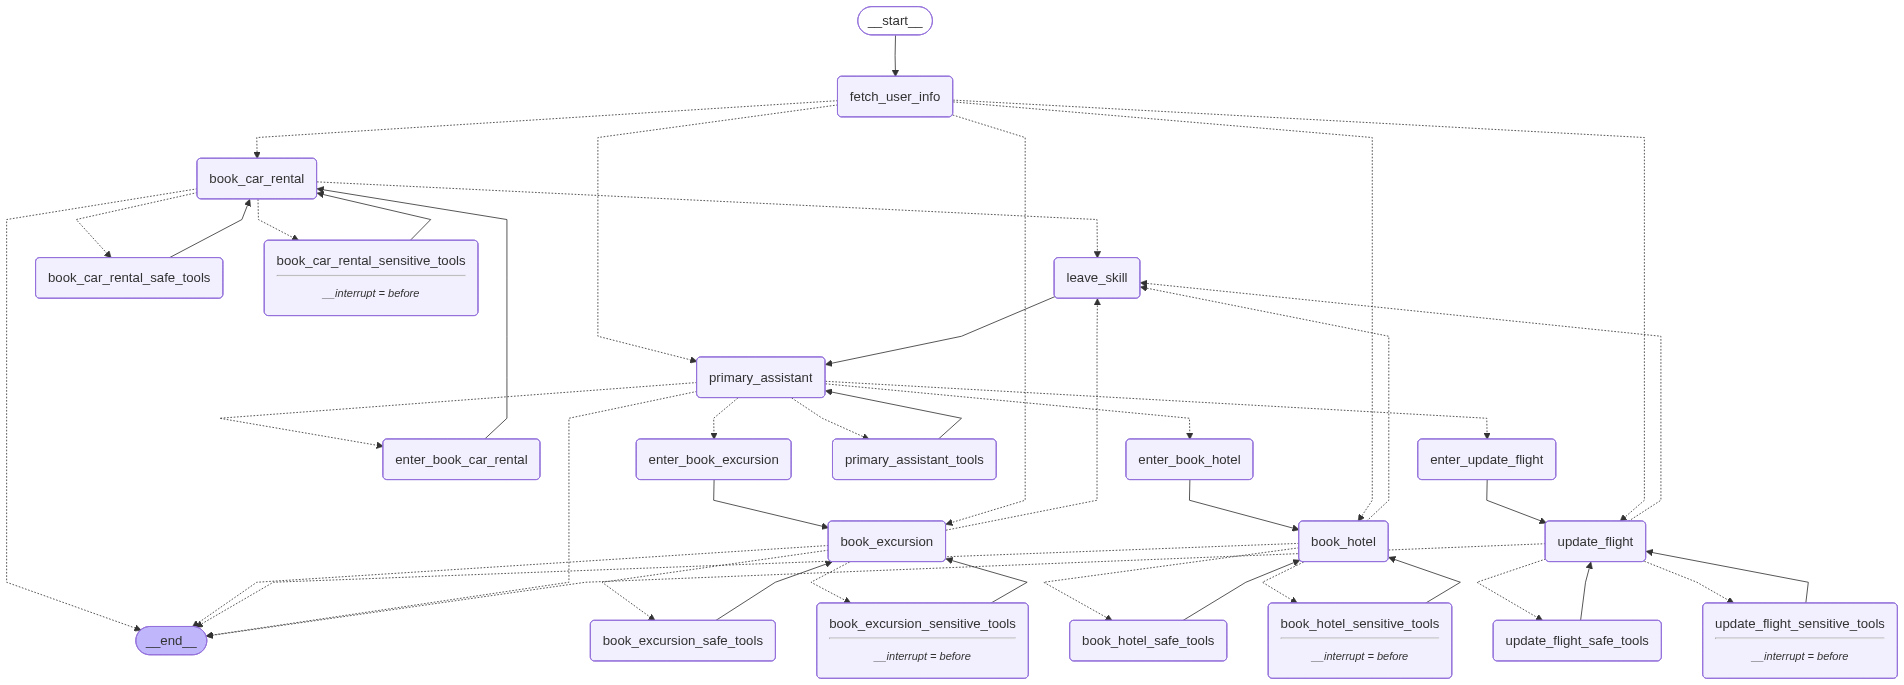

In [43]:
overall_graph

In [45]:
import shutil
import uuid

# Update with the backup file so we can restart from the original place in each section
db = update_dates(db)
thread_id = str(uuid.uuid4())

config = {
    "configurable": {
        # The passenger_id is used in our flight tools to
        # fetch the user's flight information
        "passenger_id": "3442 587242",
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

tutorial_questions = [
    "Hi there, what time is my flight?",
    "Am i allowed to update my flight to something sooner? I want to leave later today.",
    "Update my flight to sometime next week then",
    "The next available option is great",
    "what about lodging and transportation?",
    "Yeah i think i'd like an affordable hotel for my week-long stay (7 days). And I'll want to rent a car.",
    "OK could you place a reservation for your recommended hotel? It sounds nice.",
    "yes go ahead and book anything that's moderate expense and has availability.",
    "Now for a car, what are my options?",
    "Awesome let's just get the cheapest option. Go ahead and book for 7 days",
    "Cool so now what recommendations do you have on excursions?",
    "Are they available while I'm there?",
    "interesting - i like the museums, what options are there? ",
    "OK great pick one and book it for my second day there.",
]

_printed = set()
# We can reuse the tutorial questions from part 1 to see how it does.
for question in tutorial_questions:
    events = overall_graph.stream(
        {"messages": ("user", question)}, config, stream_mode="values"
    )
    for event in events:
        _print_event(event, _printed)
    snapshot = overall_graph.get_state(config)
    while snapshot.next:
        # We have an interrupt! The agent is trying to use a tool, and the user can approve or deny it
        # Note: This code is all outside of your graph. Typically, you would stream the output to a UI.
        # Then, you would have the frontend trigger a new run via an API call when the user has provided input.
        try:
            user_input = input(
                "Do you approve of the above actions? Type 'y' to continue;"
                " otherwise, explain your requested changed.\n\n"
            )
        except:
            user_input = "y"
        if user_input.strip() == "y":
            # Just continue
            result = overall_graph.invoke(
                None,
                config,
            )
        else:
            # Satisfy the tool invocation by
            # providing instructions on the requested changes / change of mind
            result = overall_graph.invoke(
                {
                    "messages": [
                        ToolMessage(
                            tool_call_id=event["messages"][-1].tool_calls[0]["id"],
                            content=f"API call denied by user. Reasoning: '{user_input}'. Continue assisting, accounting for the user's input.",
                        )
                    ]
                },
                config,
            )
        snapshot = overall_graph.get_state(config)

================================ Human Message =================================

Hi there, what time is my flight?
================================== Ai Message ==================================

Your flight LX0112 from CDG to BSL is scheduled to depart at 01:53:20 on 2025-09-20.
================================ Human Message =================================

Am i allowed to update my flight to something sooner? I want to leave later today.


Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


================================== Ai Message ==================================
Tool Calls:
  ToFlightBookingAssistant (e5ec854c-db63-4ece-8613-b98aa6622dc7)
 Call ID: e5ec854c-db63-4ece-8613-b98aa6622dc7
  Args:
    request: The user wants to update their flight to something sooner, departing later today.
Currently in:  update_flight
================================= Tool Message =================================

The assistant is now the Flight Updates & Booking Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Flight Updates & Booking Assistant, and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control. Do not mention who you are - just act as t

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  update_flight


Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  update_flight
================================== Ai Message ==================================
Tool Calls:
  search_flights (05350b7f-7929-4b7f-b866-1424e0b2b286)
 Call ID: 05350b7f-7929-4b7f-b866-1424e0b2b286
  Args:
    start_time: 2025-09-22
    end_time: 2025-09-28
    departure_airport: CDG
    arrival_airport: BSL
Currently in:  update_flight
================================= Tool Message =================================
Name: search_flights

[{"flight_id": 19232, "flight_no": "LX0112", "scheduled_departure": "2025-09-24 01:53:20.674605-04:00", "scheduled_arrival": "2025-09-24 03:23:20.674605-04:00", "departure_airport": "CDG", "arrival_airport": "BSL", "status": "Scheduled", "aircraft_code": "SU9", "actual_departure": null, "actual_arrival": null}, {"flight_id": 19251, "flight_no": "LX0112", "scheduled_departure": "2025-09-27 01:53:20.674605-04:00", "scheduled_arrival": "2025-09-27 03:23:20.674605-04:00", "departure_airport": "CDG", "arrival_airport": "BSL", "sta

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  update_flight
Currently in:  update_flight
================================== Ai Message ==================================
Tool Calls:
  update_ticket_to_new_flight (baef541d-78f1-446a-8170-ce7d43f15e60)
 Call ID: baef541d-78f1-446a-8170-ce7d43f15e60
  Args:
    ticket_no: 7240005432906569
    new_flight_id: 19287


Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  update_flight
================================ Human Message =================================

what about lodging and transportation?


Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  update_flight
Currently in:  update_flight
================================== Ai Message ==================================
Tool Calls:
  CompleteOrEscalate (2e0f91ab-c086-4432-b3d3-e2fe007055f9)
 Call ID: 2e0f91ab-c086-4432-b3d3-e2fe007055f9
  Args:
    reason: The user is asking about lodging and transportation, which is outside the scope of this flight update assistant. Escalating to the main assistant.
================================= Tool Message =================================

Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.
================================== Ai Message ==================================

I understand you're looking for lodging and transportation. To help you better, could you please tell me the location and dates you are interested in for lodging? And for transportation, are you looking for a car rental or something else?
================================ Human Message =============

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 27.009008111s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 27
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<lo

================================== Ai Message ==================================

I can certainly help you with finding a hotel and a car rental. However, I haven't recommended any specific hotel yet, as I need to know a bit more about your preferences and location.

Given your flight to Basel (BSL) on September 22nd, would you like to book the hotel and car rental in **Basel**?

If so, for the hotel, would you like your week-long stay to start on **September 22nd, 2025**, checking out on **September 29th, 2025**?

And for the car rental, would you like to pick it up in **Basel** on **September 22nd, 2025**, and drop it off on **September 29th, 2025** as well?

Once I have this information, I can delegate these tasks to the specialized assistants.
================================ Human Message =================================

yes go ahead and book anything that's moderate expense and has availability.


Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


================================== Ai Message ==================================
Tool Calls:
  ToHotelBookingAssistant (f48e0094-6af0-4799-9689-1b759fba946c)
 Call ID: f48e0094-6af0-4799-9689-1b759fba946c
  Args:
    location: Basel
    checkin_date: 2025-09-22
    request: Book a moderately priced hotel with availability for a week-long stay.
    checkout_date: 2025-09-29
  ToBookCarRental (7fecee55-141f-4b05-891a-5776db12a4d7)
 Call ID: 7fecee55-141f-4b05-891a-5776db12a4d7
  Args:
    location: Basel
    end_date: 2025-09-29
    request: Book a car rental for a week.
    start_date: 2025-09-22
Currently in:  book_hotel
================================= Tool Message =================================

The assistant is now the Hotel Booking Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Hotel Booking Assistant, and the booking, update, other other action 

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  book_hotel
================================== Ai Message ==================================
Tool Calls:
  search_hotels (f28047f4-5f24-4816-8b25-ecd72dc32eb4)
 Call ID: f28047f4-5f24-4816-8b25-ecd72dc32eb4
  Args:
    location: Basel
    checkin_date: 2025-09-22
    price_tier: Midscale
    checkout_date: 2025-09-29
Currently in:  book_hotel
================================= Tool Message =================================
Name: search_hotels

[{"id": 1, "name": "Hilton Basel", "location": "Basel", "price_tier": "Luxury", "checkin_date": "2024-04-22", "checkout_date": "2024-04-20", "booked": 0}, {"id": 3, "name": "Hyatt Regency Basel", "location": "Basel", "price_tier": "Upper Upscale", "checkin_date": "2024-04-02", "checkout_date": "2024-04-20", "booked": 0}, {"id": 8, "name": "Holiday Inn Basel", "location": "Basel", "price_tier": "Upper Midscale", "checkin_date": "2024-04-24", "checkout_date": "2024-04-09", "booked": 0}]
Currently in:  book_hotel
=======================

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  book_hotel
Currently in:  book_hotel
================================== Ai Message ==================================
Tool Calls:
  CompleteOrEscalate (9616ef6f-bd49-40f3-919b-2f0d064f0901)
 Call ID: 9616ef6f-bd49-40f3-919b-2f0d064f0901
  Args:
    reason: The user is asking about car rental options, but the car rental tool's output is not available. Escalating to the main assistant.
================================= Tool Message =================================

Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.
================================== Ai Message ==================================
Tool Calls:
  search_car_rentals (2d5b97bd-4f0a-48b1-8ce6-bdff87606b37)
 Call ID: 2d5b97bd-4f0a-48b1-8ce6-bdff87606b37
  Args:
    location: Basel
    pick_up_date: 2025-09-22
    drop_off_date: 2025-09-29
================================= Tool Message =================================
Name: search_car_rentals

Error: sea

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


================================== Ai Message ==================================
Tool Calls:
  ToBookCarRental (9514ea47-f29f-4fee-b5ab-cdfb47b5602b)
 Call ID: 9514ea47-f29f-4fee-b5ab-cdfb47b5602b
  Args:
    location: Basel
    end_date: 2025-09-29
    request: Book the cheapest car rental for 7 days.
    start_date: 2025-09-22
Currently in:  book_car_rental
================================= Tool Message =================================

The assistant is now the Car Rental Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Car Rental Assistant, and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control. Do not mention who you are - just act as the p

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  book_car_rental
================================== Ai Message ==================================
Tool Calls:
  search_car_rentals (00b8ab7f-bdfa-4c81-9e6f-d48bf4289982)
 Call ID: 00b8ab7f-bdfa-4c81-9e6f-d48bf4289982
  Args:
    location: Basel
    end_date: 2025-09-29
    price_tier: Economy
    start_date: 2025-09-22
Currently in:  book_car_rental
================================= Tool Message =================================
Name: search_car_rentals

[{"id": 1, "name": "Europcar", "location": "Basel", "price_tier": "Economy", "start_date": "2024-04-14", "end_date": "2024-04-11", "booked": 0}, {"id": 2, "name": "Avis", "location": "Basel", "price_tier": "Luxury", "start_date": "2024-04-10", "end_date": "2024-04-20", "booked": 0}, {"id": 7, "name": "Enterprise", "location": "Basel", "price_tier": "Premium", "start_date": "2024-04-22", "end_date": "2024-04-20", "booked": 0}, {"id": 9, "name": "Thrifty", "location": "Basel", "price_tier": "Midsize", "start_date": "2024-04

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  book_car_rental


Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 28.522223683s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 28
}
].


Currently in:  book_car_rental
================================== Ai Message ==================================
Tool Calls:
  CompleteOrEscalate (38e42062-dfed-446e-8dc0-1af6d8d7246a)
 Call ID: 38e42062-dfed-446e-8dc0-1af6d8d7246a
  Args:
    reason: The user is asking for recommendations on excursions, which is outside the scope of car rental bookings.
================================= Tool Message =================================

Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.


Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


================================== Ai Message ==================================

I can help you with recommendations for excursions! Since you'll be in Basel, I can look for some interesting things to do there.
Tool Calls:
  ToBookExcursion (73b5c60c-4e6d-48a2-9f62-2d02967e8b5b)
 Call ID: 73b5c60c-4e6d-48a2-9f62-2d02967e8b5b
  Args:
    location: Basel
    request: The user is looking for recommendations on excursions in Basel.
Currently in:  book_excursion
================================= Tool Message =================================

The assistant is now the Trip Recommendation Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Trip Recommendation Assistant, and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the Com

Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 22.993086854s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-limits"
}
, retry_delay {
  seconds: 22
}
].
Retrying langchain_google_genai.chat_models._chat_with_retry.<lo

Currently in:  book_excursion
================================== Ai Message ==================================
Tool Calls:
  search_trip_recommendations (55a26d8c-3e33-4c0a-815b-4615e73148c9)
 Call ID: 55a26d8c-3e33-4c0a-815b-4615e73148c9
  Args:
    location: Basel
Currently in:  book_excursion
================================= Tool Message =================================
Name: search_trip_recommendations

[{"id": 1, "name": "Basel Minster", "location": "Basel", "keywords": "landmark, history", "details": "Visit the historic Basel Minster, a beautiful Gothic cathedral.", "booked": 0}, {"id": 2, "name": "Kunstmuseum Basel", "location": "Basel", "keywords": "art, museum", "details": "Explore the extensive art collection at the Kunstmuseum Basel.", "booked": 0}, {"id": 8, "name": "Basel Zoo", "location": "Basel", "keywords": "wildlife, zoo", "details": "Spend a day exploring the diverse animal exhibits at Basel Zoo.", "booked": 0}]
Currently in:  book_excursion
========================

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  book_excursion
Currently in:  book_excursion
================================== Ai Message ==================================
Tool Calls:
  CompleteOrEscalate (1b8e5e89-ebf1-4740-a5fe-d00b2093d06c)
 Call ID: 1b8e5e89-ebf1-4740-a5fe-d00b2093d06c
  Args:
    reason: The user is asking about the availability of excursions, but the `search_trip_recommendations` tool does not provide date-specific availability. I cannot answer this question with the current tools.
================================= Tool Message =================================

Resuming dialog with the host assistant. Please reflect on the past conversation and assist the user as needed.
================================== Ai Message ==================================

I cannot check the real-time availability for specific dates and times for these excursions with the information I have. However, these are popular attractions in Basel and are generally open to the public.

I recommend checking their official w

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


================================== Ai Message ==================================
Tool Calls:
  ToBookExcursion (c20d9caf-e492-42d5-87d6-554b654abdf3)
 Call ID: c20d9caf-e492-42d5-87d6-554b654abdf3
  Args:
    location: Basel
    request: Book a visit to the Kunstmuseum Basel for September 23rd, 2025.
Currently in:  book_excursion
================================= Tool Message =================================

The assistant is now the Trip Recommendation Assistant. Reflect on the above conversation between the host assistant and the user. The user's intent is unsatisfied. Use the provided tools to assist the user. Remember, you are Trip Recommendation Assistant, and the booking, update, other other action is not complete until after you have successfully invoked the appropriate tool. If the user changes their mind or needs help for other tasks, call the CompleteOrEscalate function to let the primary host assistant take control. Do not mention who you are - just act as the proxy for the

Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring


Currently in:  book_excursion
================================== Ai Message ==================================
Tool Calls:
  search_trip_recommendations (12e99e96-e743-4655-8df1-f27184c95a0b)
 Call ID: 12e99e96-e743-4655-8df1-f27184c95a0b
  Args:
    location: Basel
    name: Kunstmuseum Basel
Currently in:  book_excursion
================================= Tool Message =================================
Name: search_trip_recommendations

[{"id": 2, "name": "Kunstmuseum Basel", "location": "Basel", "keywords": "art, museum", "details": "Explore the extensive art collection at the Kunstmuseum Basel.", "booked": 0}]
Currently in:  book_excursion
================================== Ai Message ==================================
Tool Calls:
  book_excursion (92a03938-af7e-4cba-baec-86fa1bebf922)
 Call ID: 92a03938-af7e-4cba-baec-86fa1bebf922
  Args:
    recommendation_id: 2


Key 'example 2' is not supported in schema, ignoring
Key 'example 3' is not supported in schema, ignoring
Retrying langchain_google_genai.chat_models._chat_with_retry.<locals>._chat_with_retry in 2.0 seconds as it raised ResourceExhausted: 429 You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.
* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10
Please retry in 39.798735081s. [violations {
  quota_metric: "generativelanguage.googleapis.com/generate_content_free_tier_requests"
  quota_id: "GenerateRequestsPerMinutePerProjectPerModel-FreeTier"
  quota_dimensions {
    key: "model"
    value: "gemini-2.5-flash"
  }
  quota_dimensions {
    key: "location"
    value: "global"
  }
  quota_value: 10
}
, links {
  description: "Learn more about Gemini API quotas"
  url: "https://ai.google.dev/gemini-api/docs/rate-lim